In [1]:
import numpy as np
import astropy.units as u
import yaml
import utils
import matplotlib.pyplot as plt

from gammapy.data import DataStore
from gammapy.maps import MapAxis, WcsGeom, Map
from gammapy.datasets import MapDataset
from gammapy.makers import MapDatasetMaker, SafeMaskMaker, FoVBackgroundMaker
from gammapy.modeling.models import FoVBackgroundModel, Models
from gammapy.modeling import Fit
from gammapy.irf import Background3D

import warnings
warnings.filterwarnings('ignore')

In [2]:
# loading general parameters
with open("../general_config.yml", "r") as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)
conf=cfg['conf']
hessera = 'hess1'
muoneff_flag= cfg['muoneff_flag']

muoneff_flag= False

In [3]:
# defining the geometry for the datasets
energy_bins = np.logspace(-1, 2, cfg['N_ebins']+1)
axis = MapAxis.from_edges(energy_bins, unit="TeV", name="energy", interp="log")
maker = MapDatasetMaker()
maker_safe_mask = SafeMaskMaker(methods=['offset-max'], offset_max=cfg['offset_cut'] * u.deg)

In [4]:
runlist = [20380, 50653]
muoneff_path = f'{cfg["muoneff_path"]}/{hessera}/hess1_hess2/v01c_kaori_mueff'

basedir = f'{cfg["FITS_PROD"]}/{hessera}/std_{conf}_fullEnclosure'
ds = DataStore.from_dir(basedir, f'hdu-index-bg-latest-fov-radec.fits.gz', f'obs-index-bg-latest-fov-radec.fits.gz')

table = ds.obs_table
observations = ds.get_observations(runlist)

No HDU found matching: OBS_ID = 20380, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 50653, HDU_TYPE = rad_max, HDU_CLASS = None


In [5]:
dataset_list = []
for obs in observations:
    # taking care of the correct bkg model (if it is muoneff or official model)
    # the official model is stored in the fits tables. For the muoneff model, we will just change the path of the bkg model
    if muoneff_flag:
        if obs.obs_info['MUONEFF'] > 0.085:
            model_CD = 'B'
        elif obs.obs_info['MUONEFF'] >= 0.075:
            model_CD = 'D'
        else:
            model_CD = 'C'

        if obs.obs_id >= 100000:
            run_number= f'{obs.obs_id}'
        else:
            run_number= f'0{obs.obs_id}'
        filename = f'{muoneff_path}_{model_CD}/hess_bkg_3d_v01c_kaori_mueff_{model_CD}_norebin_fov_radec_{run_number}.fits.gz'
        obs.bkg = Background3D.read(filename, hdu='BACKGROUND')

    geom = WcsGeom.create(skydir=obs.pointing_radec, binsz=cfg['binsz'], width=cfg['width']* u.deg, frame="icrs", axes=[axis])        
    
    dataset = MapDataset.create(geom=geom)
    dataset = maker.run(dataset, obs)
    dataset = maker_safe_mask.run(dataset, obs)

    # create here mask_fit
    dataset.mask_fit = Map.from_geom(geom=geom, data=np.ones_like(dataset.counts.data).astype(bool))
    coord = utils.get_mask_fov(obs.pointing_radec.ra.deg, obs.pointing_radec.dec.deg, 5)
    if coord != 0: #this means that if there are regions to be masked
        for s in coord:
            dataset.mask_fit &= ~dataset.counts.geom.region_mask(f"icrs;circle({s[0]}, {s[1]}, {s[2]})")
            
    bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
    dataset.models = Models([bkg_model])
    dataset.background_model.spectral_model.tilt.frozen = False

    Fit().run(datasets=[dataset])
    dataset_list.append(dataset)

Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


In [7]:
x_axis

array([ 0.1154782 ,  0.15399265,  0.2053525 ,  0.27384196,  0.36517413,
        0.48696753,  0.64938163,  0.86596432,  1.15478198,  1.53992653,
        2.05352503,  2.73841963,  3.65174127,  4.86967525,  6.49381632,
        8.65964323, 11.54781985, 15.39926526, 20.53525026, 27.38419634,
       36.51741273, 48.69675252, 64.93816316, 86.59643234])

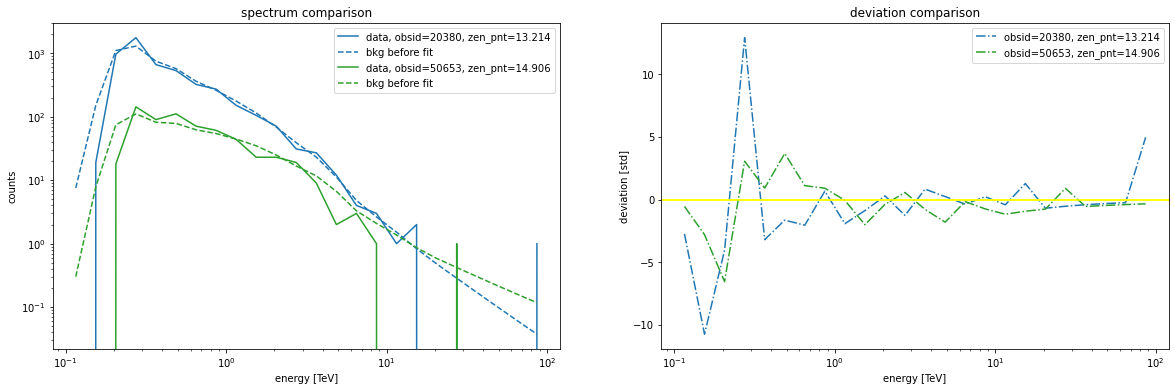

In [6]:
x_axis= dataset.counts.geom.axes['energy'].center.value

fig, ax = plt.subplots(1,2, figsize=(20, 6))
colors=['C0', 'C2', 'C3']
for i, dataset in enumerate(dataset_list):
    c = np.sum((dataset.counts*dataset.mask_fit*dataset.mask_safe).data, axis=(1,2))
    b = np.sum((dataset.background*dataset.mask_fit*dataset.mask_safe).data, axis=(1,2))
    n = np.sum((dataset.npred()*dataset.mask_fit*dataset.mask_safe).data, axis=(1,2))
    ax[0].plot(x_axis, c, label=f'data, obsid={runlist[i]}, zen_pnt={observations[i].obs_info["ZEN_PNT"]:.3f}', color=colors[i])
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].set_xlabel('energy [TeV]')
    ax[0].set_ylabel('counts')
    ax[0].set_title(f'spectrum comparison')
    ax[0].plot(x_axis, n, label='bkg before fit', ls='--', color=colors[i])
    ax[0].legend(loc='upper right')
    
    ax[1].plot(x_axis, (c-n)/np.sqrt(n), label=f'obsid={runlist[i]}, zen_pnt={observations[i].obs_info["ZEN_PNT"]:.3f}', color=colors[i], ls='-.')
    ax[1].set_xscale('log')
    ax[1].set_xlabel('energy [TeV]')
    ax[1].set_ylabel('deviation [std]')
    ax[1].set_title(f'deviation comparison')
    ax[1].legend(loc='upper right')
    ax[1].axhline(0, color='yellow')


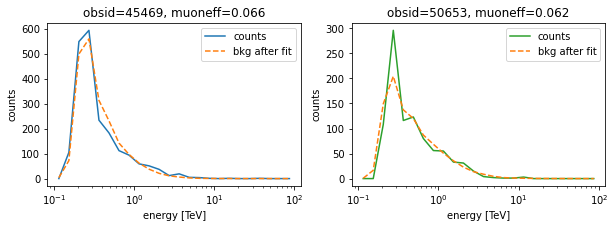

In [11]:
x_axis= dataset.counts.geom.axes['energy'].center.value


for i, dataset in enumerate(dataset_list):
    fig, ax = plt.subplots(1,2, figsize=(10, 3))
    
    c = np.sum((dataset.counts*dataset.mask_fit*dataset.mask_safe).data, axis=(1,2))
    b = np.sum((dataset.npred()*dataset.mask_fit*dataset.mask_safe).data, axis=(1,2))
    ax[0].plot(x_axis, c, label='counts', color=colors[i])
    ax[0].plot(x_axis, b, label='bkg after fit', ls='--', color='C1')
    ax[0].set_xscale('log')
    #ax[i].set_yscale('log')
    ax[0].legend()
    ax[0].set_xlabel('energy [TeV]')
    ax[0].set_ylabel('counts')
    ax[0].set_title(f'obsid={runlist[i]}, muoneff={observations[i].obs_info["MUONEFF"]:.3f}')

    ax[1]
    plt.show()

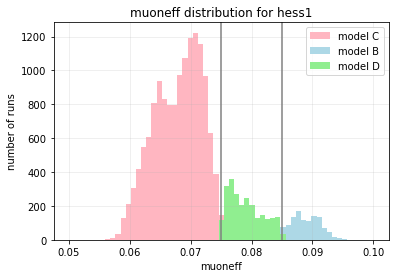

In [47]:
mask1= table['MUONEFF'] < 0.075
plt.hist(table['MUONEFF'][mask1], bins=np.linspace(0.05,0.1,60), color='lightpink', label='model C')
mask2= table['MUONEFF'] > 0.085
plt.hist(table['MUONEFF'][mask2], bins=np.linspace(0.05,0.1,60), color='lightblue', label='model B')
plt.hist(table['MUONEFF'][~(mask1 + mask2)], bins=np.linspace(0.05,0.1,60), color='lightgreen', label='model D')

plt.ylabel('number of runs')
plt.xlabel('muoneff')
plt.grid(alpha=0.25)
plt.title('muoneff distribution for hess1')
plt.axvline(0.075, color='gray')
plt.axvline(0.085, color='gray')
plt.legend()

In [53]:
muoneff_flag= True
runlist = [18415, 80170]
muoneff_path = f'{cfg["muoneff_path"]}/{hessera}/hess1_hess2/v01c_kaori_mueff'

basedir = f'{cfg["FITS_PROD"]}/{hessera}/std_{conf}_fullEnclosure'
ds = DataStore.from_dir(basedir, f'hdu-index-bg-latest-fov-radec.fits.gz', f'obs-index-bg-latest-fov-radec.fits.gz')

table = ds.obs_table
observations = ds.get_observations(runlist)

No HDU found matching: OBS_ID = 18415, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 80170, HDU_TYPE = rad_max, HDU_CLASS = None


In [54]:
dataset_list = []
for obs in observations:
    # taking care of the correct bkg model (if it is muoneff or official model)
    # the official model is stored in the fits tables. For the muoneff model, we will just change the path of the bkg model
    if muoneff_flag:
        if obs.obs_info['MUONEFF'] > 0.085:
            model_CD = 'B'
        elif obs.obs_info['MUONEFF'] >= 0.075:
            model_CD = 'D'
        else:
            model_CD = 'C'

        if obs.obs_id >= 100000:
            run_number= f'{obs.obs_id}'
        else:
            run_number= f'0{obs.obs_id}'
        filename = f'{muoneff_path}_{model_CD}/hess_bkg_3d_v01c_kaori_mueff_{model_CD}_norebin_fov_radec_{run_number}.fits.gz'
        obs.bkg = Background3D.read(filename, hdu='BACKGROUND')

    geom = WcsGeom.create(skydir=obs.pointing_radec, binsz=cfg['binsz'], width=cfg['width']* u.deg, frame="icrs", axes=[axis])        
    
    dataset = MapDataset.create(geom=geom)
    dataset = maker.run(dataset, obs)
    dataset = maker_safe_mask.run(dataset, obs)

    # create here mask_fit
    dataset.mask_fit = Map.from_geom(geom=geom, data=np.ones_like(dataset.counts.data).astype(bool))
    coord = utils.get_mask_fov(obs.pointing_radec.ra.deg, obs.pointing_radec.dec.deg, 5)
    if coord != 0: #this means that if there are regions to be masked
        for s in coord:
            dataset.mask_fit &= ~dataset.counts.geom.region_mask(f"icrs;circle({s[0]}, {s[1]}, {s[2]})")
            
    bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
    dataset.models = Models([bkg_model])
    dataset.background_model.spectral_model.tilt.frozen = False

    Fit().run(datasets=[dataset])
    dataset_list.append(dataset)

Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


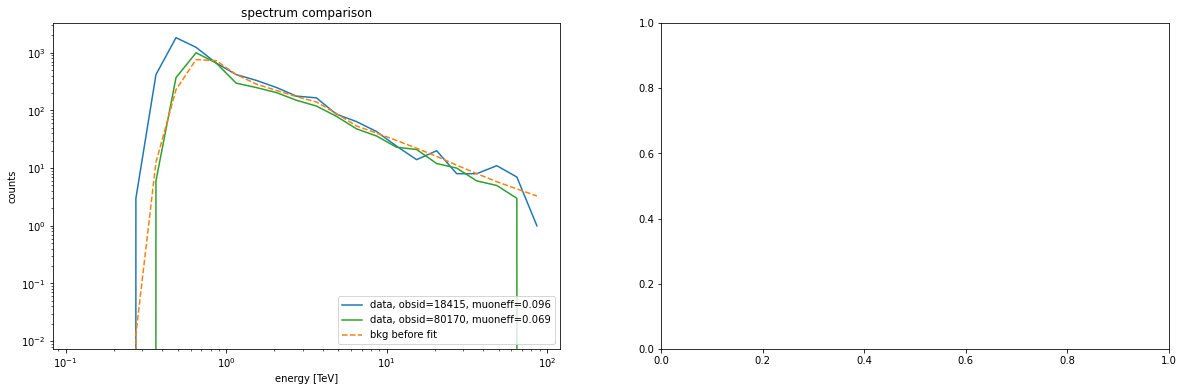

In [55]:
x_axis= dataset.counts.geom.axes['energy'].center.value

fig, ax = plt.subplots(1,2, figsize=(20, 6))
colors=['C0', 'C2', 'C3']
for i, dataset in enumerate(dataset_list):
    c = np.sum((dataset.counts*dataset.mask_fit*dataset.mask_safe).data, axis=(1,2))
    b = np.sum((dataset.background*dataset.mask_fit*dataset.mask_safe).data, axis=(1,2))
    ax[0].plot(x_axis, c, label=f'data, obsid={runlist[i]}, muoneff={observations[i].obs_info["MUONEFF"]:.3f}', color=colors[i])
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].set_xlabel('energy [TeV]')
    ax[0].set_ylabel('counts')
    ax[0].set_title(f'spectrum comparison')
ax[0].plot(x_axis, b, label='bkg before fit', ls='--', color='C1')
ax[0].legend(loc='lower right')

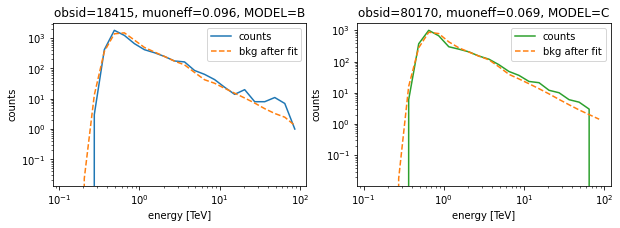

In [59]:
x_axis= dataset.counts.geom.axes['energy'].center.value

fig, ax = plt.subplots(1,2, figsize=(10, 3))

model_list = ['B', 'C']
for i, dataset in enumerate(dataset_list):
    c = np.sum((dataset.counts*dataset.mask_fit*dataset.mask_safe).data, axis=(1,2))
    b = np.sum((dataset.npred()*dataset.mask_fit*dataset.mask_safe).data, axis=(1,2))
    ax[i].plot(x_axis, c, label='counts', color=colors[i])
    ax[i].plot(x_axis, b, label='bkg after fit', ls='--', color='C1')
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].legend()
    ax[i].set_xlabel('energy [TeV]')
    ax[i].set_ylabel('counts')
    ax[i].set_title(f'obsid={runlist[i]}, muoneff={observations[i].obs_info["MUONEFF"]:.3f}, MODEL={model_list[i]}')
    ax[i]